Available cities: Agra, Ahmedabad, Bengaluru, Bhubaneswar, Chennai, Delhi, Goa, Hyderabad, Jaipur, Kanpur, Kochi, Kolkata, Lucknow, Mumbai, Patna, Pune, Thiruvananthapuram, Udaipur, Varanasi, Vishakhapatnam
Enter the start city: Bhubaneswar
Enter the destination city: Mumbai
Cheapest route from Bhubaneswar to Mumbai is: Bhubaneswar -> Vishakhapatnam -> Hyderabad -> Mumbai
Total Distance (in Km): 1770
Total Price: 7950


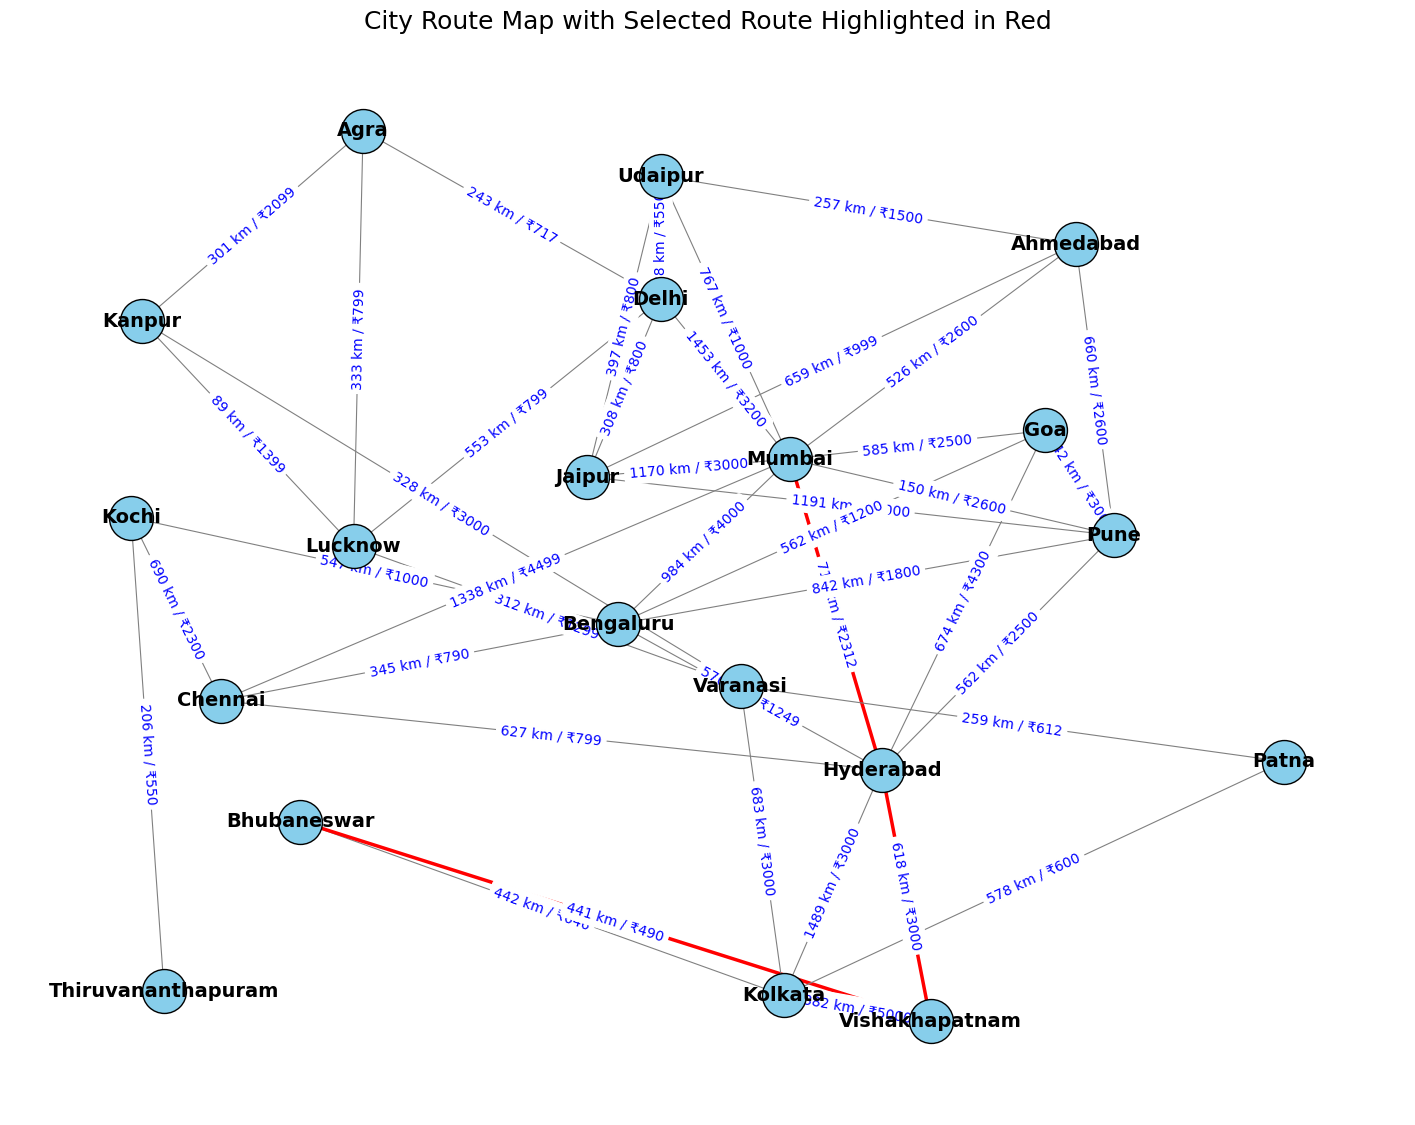

In [2]:
import csv
import heapq
import networkx as nx
import matplotlib.pyplot as plt

# Modified Graph class to include price as a metric
class Graph:
    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    # Method to make the graph undirected by adding reverse edges
    def make_undirected(self):
        for a in list(self.graph_dict.keys()):
            for b, values in self.graph_dict[a].items():
                self.graph_dict.setdefault(b, {})[a] = values

    # Method to connect two cities with a given distance and price
    def connect(self, A, B, distance=1, price=0):
        self.graph_dict.setdefault(A, {})[B] = {'distance': distance, 'price': price}
        if not self.directed:
            self.graph_dict.setdefault(B, {})[A] = {'distance': distance, 'price': price}

    # Method to get neighbors of a city
    def get(self, a, b=None):
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

# Function to read data from CSV file
def read_csv(filename):
    data = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append(row)
    return data

# Function to extract graph from the CSV data
def extract_graph(data):
    graph = Graph()
    for row in data:
        source = row['Source']
        destination = row['Destination']
        distance = int(row['distance'])
        price = int(row['price'])
        graph.connect(source, destination, distance, price)
    return graph

# A* search algorithm prioritizing minimum price
def astar_search_min_price(graph, start, end):
    open_list = []  # Priority queue for nodes to explore
    heapq.heappush(open_list, (0, 0, start, []))  # Initialize queue with (price, distance, city, path)
    visited = set()  # Track visited cities

    while open_list:
        total_price, total_distance, current_city, path = heapq.heappop(open_list)

        if current_city == end:  # Destination reached
            path.append(current_city)
            return path, total_distance, total_price

        if current_city not in visited:
            visited.add(current_city)
            for neighbor, values in graph.get(current_city).items():
                distance = values['distance']
                price = values['price']
                new_price = total_price + price
                new_distance = total_distance + distance
                heapq.heappush(open_list, (new_price, new_distance, neighbor, path + [current_city]))

    return None, float('inf'), float('inf')  # No path found

# Function to visualize the graph and highlight the selected route
def visualize_graph(graph, path):
    G = nx.Graph()  # Create a NetworkX graph

    # Add edges to the graph
    for city, neighbors in graph.graph_dict.items():
        for neighbor, values in neighbors.items():
            G.add_edge(city, neighbor, distance=values['distance'], price=values['price'])

    # Define colors and widths for edges
    edge_colors = []
    edge_widths = []
    for edge in G.edges():
        if edge in zip(path, path[1:]) or (edge[1], edge[0]) in zip(path, path[1:]):
            edge_colors.append('red')  # Color the path in red
            edge_widths.append(2.5)    # Make the path thicker
        else:
            edge_colors.append('gray')  # Other edges in gray
            edge_widths.append(0.8)     # Thinner for non-path edges

    # Draw the graph with increased figure size and larger, clearer elements
    plt.figure(figsize=(18, 14))  # Larger figure size
    pos = nx.spring_layout(G, seed=42, k=1.2)  # Increase the spacing between nodes

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={(u, v): f"{d['distance']} km / ₹{d['price']}" for u, v, d in G.edges(data=True)},
        font_size=10, font_color='blue'
    )

    plt.title("City Route Map with Selected Route Highlighted in Red", fontsize=18)
    plt.axis('off')
    plt.show()

# Main function to handle console inputs and display results
def main():
    # Read data from CSV file and extract the graph
    data = read_csv('cleaned_bus.csv')
    graph = extract_graph(data)

    # Extract unique cities from the dataset for reference
    unique_cities = sorted(set(row['Source'] for row in data).union(set(row['Destination'] for row in data)))

    # Get user inputs for start and destination cities
    print("Available cities:", ', '.join(unique_cities))
    start_city = input("Enter the start city: ").strip()
    end_city = input("Enter the destination city: ").strip()
    
    # Validate input cities
    if start_city not in unique_cities or end_city not in unique_cities:
        print("Error: One or both cities are not in the dataset.")
        return
    if start_city == end_city:
        print("Error: Start and destination cities cannot be the same.")
        return

    # Call A* search algorithm and display the result
    path, total_distance, total_price = astar_search_min_price(graph, start_city, end_city)
    if path:
        print("Cheapest route from {} to {} is: {}".format(start_city, end_city, ' -> '.join(path)))
        print("Total Distance (in Km):", total_distance)
        print("Total Price:", total_price)
        visualize_graph(graph, path)  # Visualize the graph with the path highlighted
    else:
        print("No path found between {} and {}.".format(start_city, end_city))

# Entry point of the program
if __name__ == "__main__":
    main()
